## Accessing NAIP data with the Planetary Computer STAC API

The [National Agriculture Imagery Program](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/) (NAIP) provides US-wide, high-resolution aerial imagery, with four spectral bands (R, G, B, IR).  NAIP is administered by the [Aerial Field Photography Office](https://www.fsa.usda.gov/programs-and-services/aerial-photography/) (AFPO) within the [US Department of Agriculture](https://www.usda.gov/) (USDA).  Data are captured at least once every three years for each state.  This dataset represents NAIP data from 2010-present, in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates the use of the Planetary Computer STAC API to query for NAIP imagery.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
from pystac_client import Client
import planetary_computer as pc

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

### Choose our region and times of interest

This area is in South Jordan, Utah, which the Internet says is one of the fastest-growing cities in the US.  Let's see whether we can see some development in this area in the time spanned by our NAIP collection.

In [2]:
# area_of_interest = {
#     "type": "Polygon",
#     "coordinates": [
#         [
#             [-111.9839859008789, 40.5389819819361],
#             [-111.90502166748045, 40.5389819819361],
#             [-111.90502166748045, 40.57015381856105],
#             [-111.9839859008789, 40.57015381856105],
#             [-111.9839859008789, 40.5389819819361],
#         ]
#     ],
# }

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [[-119.9430129709,34.3816220567],
         [-119.7733471168,34.3816220567],
         [-119.7733471168,34.456316267],
         [-119.9430129709,34.456316267],
         [-119.9430129709,34.3816220567]]],
}

### Search the collection and choose scenes to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to search for data from the [NAIP](http://aka.ms/ai4edata-naip) collection.  This collection includes data from 2010 to 2019, so we'll search for one image near the beginning of that range, and one near the end.

In [3]:
range_old = "2010-01-01/2013-01-01"
range_new = "2018-01-01/2020-01-01"

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search_old = catalog.search(
    collections=["naip"], intersects=area_of_interest, datetime=range_old
)

search_new = catalog.search(
    collections=["naip"], intersects=area_of_interest, datetime=range_new
)

items_old = list(search_old.get_items())
items_new = list(search_new.get_items())

print(f"{len(items_old)} Items found in the 'old' range")
print(f"{len(items_new)} Items found in the 'new' range")

8 Items found in the 'old' range
8 Items found in the 'new' range


As seen above, there are multiple items that intersect our area of interest for each year. The following code will choose the item that has the most overlap:

In [5]:
from shapely.geometry import shape

area_shape = shape(area_of_interest)
target_area = area_shape.area


def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    return overlap_area / target_area


item_old = sorted(items_old, key=area_of_overlap, reverse=True)[0]
item_new = sorted(items_new, key=area_of_overlap, reverse=True)[0]

In [6]:
import rasterio
item = item_new

href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
aoi_bounds = features.bounds(area_of_interest)
warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
#rgb = ds.read(indexes=[1, 2, 3], window=aoi_window)

In [7]:
ds.height

12340

In [8]:
nir = ds.read(4)

In [9]:
ds.transform

Affine(0.6, 0.0, 235476.0,
       0.0, -0.6, 3814572.0)

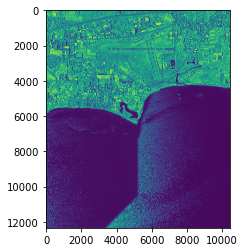

In [10]:
import matplotlib.pyplot as plt
plt.imshow(nir)

In [25]:
nir.shape

(12340, 10420)

In [11]:
outfp = "/home/jovyan/NAIP_trials/SB_nir.tif"

with rasterio.open(
    outfp,
    'w',
    driver='GTiff',
    height=nir.shape[0],
    width=nir.shape[1],
    count=1,  # number of raster bands in the dataset
    dtype=nir.dtype,
    crs=ds.crs,
    transform=ds.transform,
) as dst:
    dst.write(nir, 1)

In [12]:
import rioxarray as rioxr

nir_r = rioxr.open_rasterio(outfp)
nir_r

<xarray.DataArray (band: 1, y: 12340, x: 10420)>
[128582800 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.355e+05 2.355e+05 ... 2.417e+05 2.417e+05
  * y            (y) float64 3.815e+06 3.815e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [13]:
nir_r = nir_r.squeeze()

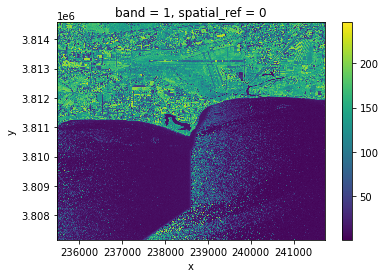

In [19]:
nir_r.plot.imshow()

In [21]:
rgb = ds.read(indexes=[1, 2, 3])
rgb

array([[[133,  54,  45, ..., 171, 170, 169],
        [127,  51,  44, ..., 168, 168, 167],
        [127,  50,  42, ..., 103, 105, 123],
        ...,
        [ 40,  39,  39, ...,  21,  21,  25],
        [ 38,  39,  36, ...,  21,  21,  25],
        [ 39,  42,  40, ...,  20,  22,  24]],

       [[134,  54,  54, ..., 173, 172, 170],
        [131,  53,  51, ..., 169, 168, 168],
        [127,  57,  51, ..., 111, 113, 124],
        ...,
        [ 52,  51,  52, ...,  39,  40,  39],
        [ 54,  52,  51, ...,  38,  40,  42],
        [ 51,  53,  52, ...,  39,  38,  40]],

       [[121,  69,  72, ..., 164, 163, 163],
        [117,  72,  70, ..., 157, 157, 158],
        [118,  71,  68, ..., 116, 119, 127],
        ...,
        [ 76,  74,  75, ...,  65,  67,  66],
        [ 73,  74,  74, ...,  65,  66,  68],
        [ 76,  76,  75, ...,  66,  66,  67]]], dtype=uint8)

In [23]:
rgb.shape

(3, 12340, 10420)

In [27]:
outfp = "/home/jovyan/NAIP_trials/SB_rgb.tif"

with rasterio.open(
    outfp,
    'w',
    driver='GTiff',
    height=rgb.shape[1],
    width=rgb.shape[2],
    count=3,  # number of raster bands in the dataset
    dtype=rgb.dtype,
    crs=ds.crs,
    transform=ds.transform,
) as dst:
    dst.write(rgb, [1,2,3])

In [28]:
rgb_r = rioxr.open_rasterio(outfp)
rgb_r


<xarray.DataArray (band: 3, y: 12340, x: 10420)>
[385748400 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.355e+05 2.355e+05 ... 2.417e+05 2.417e+05
  * y            (y) float64 3.815e+06 3.815e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

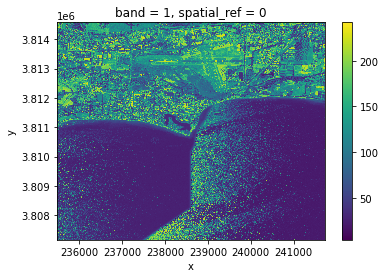

In [30]:
rgb_r.sel(band=1).plot.imshow()

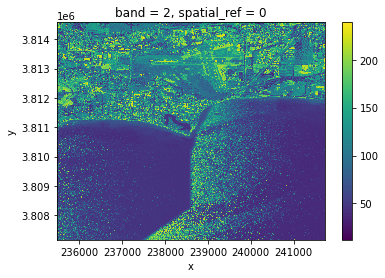

In [31]:
rgb_r.sel(band=2).plot.imshow()

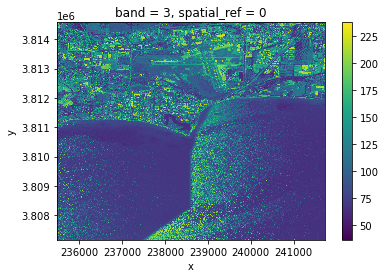

In [32]:
rgb_r.sel(band=3).plot.imshow()

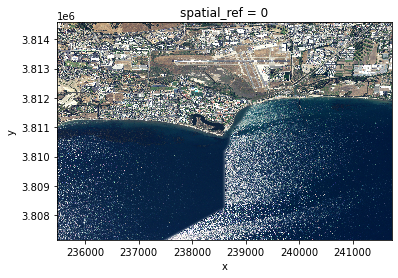

In [33]:
rgb_r.plot.imshow(robust=True)

https://carpentries-incubator.github.io/geospatial-python/05-raster-structure/index.html

https://github.com/carmengg/mexico_rasters

https://carmengg.github.io/my_coding_website/posts/2021-05-28-mexico-rasters/

https://rasterio.readthedocs.io/en/latest/quickstart.html

https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetWriter.write

https://docs.google.com/document/d/1YVZsB9XHzFcVRQq8ANzfVDi7VurKjrdhnJG2v6WoffQ/edit

https://boundingbox.klokantech.com

### Render images

Each Item has an `href` field containing a URL to the underlying image. For NAIP, these URLs are publicly-accessible, but for some data sets, these URLs may point to private containers, so we demonstrate the use of the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package's `pc.sign` method, which adds a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) to the URL, after which it can be used by any tooling that expects a standard URL.

In [6]:
def create_image(item):
    print(item.datetime)
    href = pc.sign(item.assets["image"].href)
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(indexes=[1, 2, 3], window=aoi_window)

    img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    w = img.size[0]
    h = img.size[1]
    aspect = w / h

    # Downscale a bit for plotting
    target_w = 800
    target_h = (int)(target_w / aspect)

    return img.resize((target_w, target_h), Image.BILINEAR)

2012-05-05 00:00:00+00:00


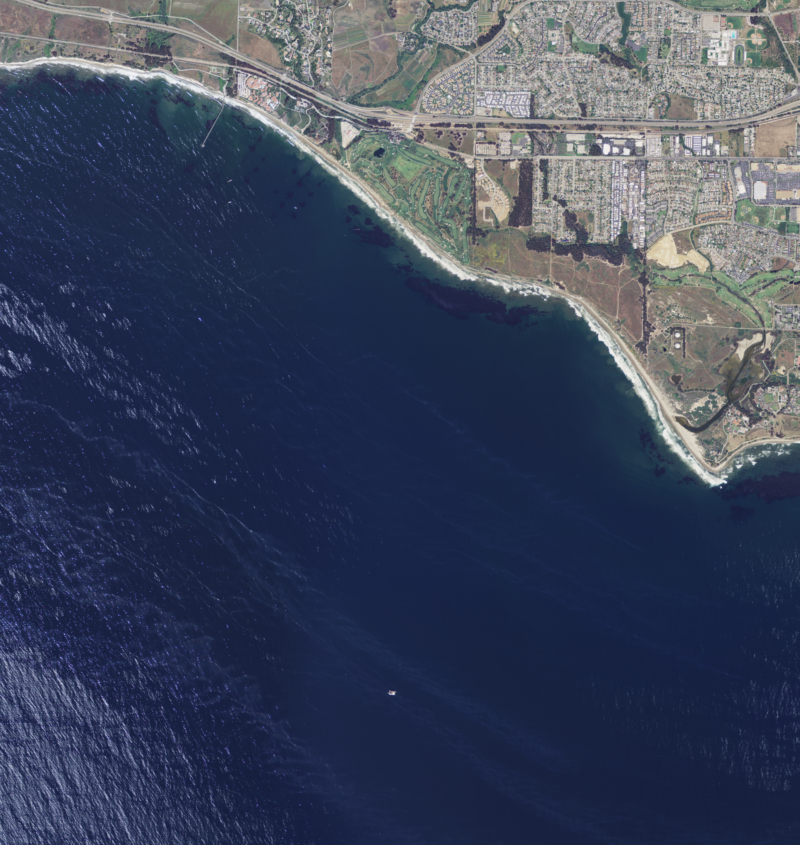

In [7]:
create_image(item_old)

2018-07-22 00:00:00+00:00


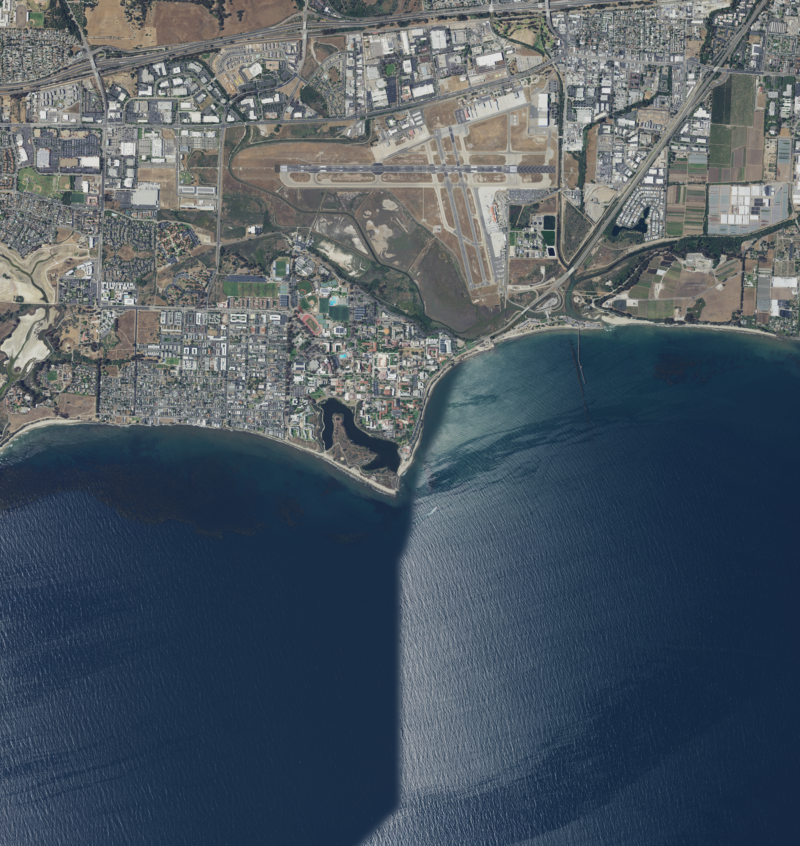

In [8]:
create_image(item_new)